# Winter school - paramak trial
Most of this script method is based on:
 
Freidberg, J. P. et al. _“Designing a Tokamak Fusion reactor—How Does Plasma Physics
Fit In?”_ 

Physics of Plasmas 22, 7 (July 2015): 070901 © 2015 AIP Publishing


## Imports 

In [2]:
import paramak
import numpy as np

## Engineering and nuclear physics constraints  

In [3]:
# Electric plant 
P_electric = 1000e6 # [W]
thermal_efficiency = 0.4 # [-]

# Nuclear physics 
fast_neutrons_Li7_slowing_down_cross_section = 2e-28 # [barns to m2]
slow_neutrons_Li6_breeding_cross_section = 960e-28 # [barns to m2] - at 0.025eV
thermal_neutron_energy = 0.025 # [eV]
fast_neutron_energy = 14.1e6 # [eV]

# Heat flux 
neutron_wall_loading_limit = 4e6 # [W/m2]

# Magnetic 
max_TF_stress = 600e6 # [Pa]
max_TF_on_coil_field = 13 # [T]
max_coil_current_density = 20e6 # [Amp/m2]

max_power_recirculation = 0.10 # [-]

# Plasma heating 
wall_to_absorbed_RF_power_conversion_efficiency = 0.4 # [-]

# Plasma 
average_plasma_temperature = 14e3 # [eV]


## Plasma shape

In [4]:
# Aspect ratio
A = 4 # [-]

# Plasma elongation 
k = 1.7 # [-]

## Blanket thickness
"_In fact, it is not unreasonable to say that the
entire scale of a fusion reactor is largely determined by the
slowing down mean free path of 14.1 MeV neutrons in lithium_" 

"_The calculation below presents a simple model for determining the width of 
the combined slowing down and breeding sub-regions. These are the dominant contributions to the blanket size which is only 
slightly less than the overall width b_"

In [5]:
# Define Lithium number density 
Li7_number_density = 4.6e28 # [atoms/m3]
Li6_number_density = 0.34e28 # [atoms/m3]

# Calculate mean free path for neutrons slowing down by Li7 and for neutron tritium breeding in Li6 
neutron_slowing_down_mean_free_path = 1/(Li7_number_density*fast_neutrons_Li7_slowing_down_cross_section)
tritium_breeding_mean_free_path = 1/(Li6_number_density*slow_neutrons_Li6_breeding_cross_section)

# Output vs input neutron flux ratio
ratio_flux_in_wrt_out = 10e5 # [-] - Output flux/input flux

alpha_B = (tritium_breeding_mean_free_path/neutron_slowing_down_mean_free_path)*((fast_neutron_energy/thermal_neutron_energy)**0.5)
blanket_thickness = neutron_slowing_down_mean_free_path*np.log(1 + alpha_B*np.log(ratio_flux_in_wrt_out))
print('Resultant blanket thickness: ' + str(round(blanket_thickness, 2)) + 'm')

# Define thickness of auxiliary wall components, 
# e.g., vacuum vessel, first_wall, shield, neutron multiplier 
first_wall_shield_vacuum_vessel_thickness = 0.1 # [m]
blanket_rear_wall_thickness = 0.25 # [m]

b = blanket_thickness + first_wall_shield_vacuum_vessel_thickness + blanket_rear_wall_thickness 

print('Total first wall + vacuum vessel + blanket + rear wall shield thickness: ' + str(round(b, 2)) + 'cm')

Resultant blanket thickness: 0.99m
Total first wall + vacuum vessel + blanket + rear wall shield thickness: 1.34cm


## Major radius
We use the wall neutron power loading limit (MW/m2) and the assumed reactor 
electric power to calculate the major radius of the plasma by knowing that: 

$P_n = S*P_{lim-wall}$

We can calculate $P_{neutron}$ by knowing the total electrical power, the 
power conversion efficiency and the added energy from the exothermic tritium breeding 
reactions. 

The surface area is defined by: 

$S \approx 4\pi^2R_0a[(1 + k^2)^{0.5}]$ 

The results is that the major radius scales inversely with a but is independent of the magnetic field B0. 


In [6]:
# Total energy from neutrons, alpha particles and exothermic tritium production
# e.g., 22.6MeV = 14.1MeV + 3.5Mev + 4.8MeV 
energy_alpha = 3.5e6 # [eV]
energy_tritium_production = 4.8e6 # [eV]
energy_fusion = fast_neutron_energy + energy_alpha + energy_tritium_production # [eV] 

# Calculate major radius R0
R0 = (((1/(4*np.pi**2))*(fast_neutron_energy/energy_fusion)*(P_electric/(thermal_efficiency*neutron_wall_loading_limit))*((2/(1 + k**2))**(0.5)))*4)**0.5
print('Resultant major radius: ' + str(round(R0, 2)) + 'm')

Resultant major radius: 5.35m


## Central toroidal magnetic field
Getting the toroidal magnetic field at the centre of the plasma is straight forward
since it scales with radius from the peak field-on-coil: 

$B(R)/B_0 = R/R_0$ 

Where:

$B(R_0) = B_0 =$ peak field-on-coil (T) 

In [7]:
# Calculate the minor radius from the major radius and the aspect ratio
a = R0/A 

# Define the gap from the first wall to the plasma
plasma_wall_gap = 0.0 # 0.05 # [m] leave at 0m for now (simplified model)

# Calculate B0 at R0
B0 = max_TF_on_coil_field*(1 - (a + b + plasma_wall_gap)/R0)

print('Minor radius: ' + str(round(a, 2)))
print('Resultant central magnetic field: ' + str(round(B0, 2)) + ' Tesla')

Minor radius: 1.34
Resultant central magnetic field: 6.49 Tesla


## Toroidal field coil thickness 
Our simplified toroidal field coils are made up only of superconducting magnet materials 
and mechanical support materials. The total radial coil thickness is therefor given by: 

$c = c_J + c_M $ 

The main forces affecting $C_M$ are the tensile and the centering forces. The main parameter affecting $C_J$ is the max current density limit. 

In [8]:
mu_0 = 1.256e-6 # [N/A2] - vacuum permeability 
e_B = (a + b)/R0 # ratio of distance from centre of plasma-to-coil to the major radius 

# Calculate mechanical support thickness 
a_M = ((B0**2)/(mu_0*max_TF_stress))*((2*e_B/(1+e_B)) + 0.5*np.log((1+e_B)/(1-e_B)))
mech_thickness = R0*(1 - e_B - ((1-e_B)**2 - a_M)**0.5)
print('Resultant radial thickness of mechanical supports: ' + str(round(mech_thickness, 2)) + 'm')

# Calcuclate conductor thickness
a_J = 2*B0/(mu_0*R0*max_coil_current_density)
conductor_thickness = R0*(1 - e_B - ((1-e_B)**2 - a_J)**0.5)
print('Resultant radial thickness of magnet conductor: ' + str(round(conductor_thickness, 2)) + 'm')

# Calculate total thickness 
tf_radial_thickness = conductor_thickness + mech_thickness
print('Resultant total magnet radial thickness: ' + str(round(tf_radial_thickness, 2)) + 'm')


Resultant radial thickness of mechanical supports: 0.39m
Resultant radial thickness of magnet conductor: 0.58m
Resultant total magnet radial thickness: 0.97m


## Number of toroidal field coils 
We can easily calculate the number of toroidal field coils by know the limit of 
the toroidal field ripple.  

In [9]:
max_tf_field_ripple = 0.02 # [-] 

tf_return_inner_radius = R0 + a + b
number_tf_coils = int(np.log(max_tf_field_ripple)/np.log((R0+a)/tf_return_inner_radius))
print('Estimated number of toroidal field coils: ' + str(number_tf_coils))

Estimated number of toroidal field coils: 21


## Average plasma temperature 
The plasma temperature is chosen as to maximuse the fusion power density. The temperature profile is fairly flat at the peak power density so we can choose a fitting temperature around the peak. 

This is the volume-average temperature. 

In [10]:
plasma_temperature = 14e3 # [eV]
print('The required volume-averaged plasma temperature is: ' + str(round(plasma_temperature, 2)) + 'eV')

The required volume-averaged plasma temperature is: 14000.0eV


## Average plasma pressure
We can get the required average plasma pressure again to maximise the fusion power. 

From that, we can calculate the resultant beta, eg. the ratio of the plasma pressure to the magnetic pressure. 

In [46]:
plasma_pressure = 1.01e5*(8.76/(a**0.5)) # [Pa]
print('The required volume-averaged plasma pressure is: ' + str(round(plasma_pressure, 2)) + 'Pa')

# Calculate beta - the ration of the plasma pressure to the magnetic pressure. 
# This is a good indicator of the economic situation. 
beta = 100*(2*mu_0*(plasma_pressure))/(B0**2)
print('Resultant beta: ' + str(round(beta, 2)) + '%')


The required volume-averaged plasma pressure is: 765301.54Pa
Resultant beta: 4.57%


## Average plasma density 
The volume-average plasma density can be derived from its relationship to the plasma pressure and temperature. 
 

In [68]:
plasma_density = 1.66/(a**0.5)
print('The required volume-averaged plasma density is: ' + str(round(plasma_density, 2)) + 'e20/m3')


The required volume-averaged plasma density is: 1.44e20/m3


## Energy confinement time 
The energy confinement time is determined by the requirement that in steady 
state the thermal conduction losses are balanced by alpha particle heating. 

The plasma is assumed to be ignited.

In [13]:
confinement_time = 3*(np.pi**2)*R0*(a**2)*k*plasma_pressure*((energy_fusion*thermal_efficiency)/(energy_alpha*P_electric))
print('Required energy confinement time: ' + str(round(confinement_time, 2)) + 's')

Required energy confinement time: 0.94s


## Plasma current 
Calculating the plasma current involves some plasma physics for the first time in this project. 

We equate the required energy confinement factor to the empirically determined expression for confinement time, which then lets us solve for the plasma current. 

In [55]:
# Calculate plasma current 
H = 1  # [-] H-mode enhancement factor 
am = 2.5 # [-] atomic mass number

Ip = ((7.98*(confinement_time**1.08))/((H**1.08)*(R0**1.49)*(a**0.62)*(k**0.84)*((plasma_density)**0.44)*(B0**0.16)*(am**0.20)))*(((energy_alpha*P_electric*1e-6)/(energy_fusion*thermal_efficiency))**0.74)
print('Required plasma current: ' + str(round(Ip, 2)) + 'MA')

# Calculate resultant safety factor
safety_factor = ((2*np.pi*(a**2)*B0)/(mu_0*R0*(Ip*1e6)))*((1 + k**2)/2)
print('Resultant safety factor: ' + str(round(safety_factor, 2))) 



Required plasma current: 14.34MA
Resultant safety factor: 1.47


## CAD model generation - Paramak

In [15]:
inner_bore_radial_thickness = 50
inner_plasma_gap = 10 # [cm]
outer_plasma_gap = inner_plasma_gap # [cm]
vertical_plasma_gap = 50 # [cm]
rear_blanket_to_tf_gap = 0 # [cm]
cad_rotation_angle = 180 # [deg]
outboard_tf_coil_poloidal_thickness = 50 # [cm]
triangularity = 0.55 # [-]


In [16]:
ball_reactor = paramak.BallReactor(
   inner_bore_radial_thickness=inner_bore_radial_thickness, #
   inboard_tf_leg_radial_thickness=tf_radial_thickness*100, #
   center_column_shield_radial_thickness=b*100, #
   divertor_radial_thickness=150, #
   inner_plasma_gap_radial_thickness=inner_plasma_gap, #
   plasma_radial_thickness=100*(2*a), #
   outer_plasma_gap_radial_thickness=outer_plasma_gap, #
   plasma_gap_vertical_thickness=vertical_plasma_gap, # 
   firstwall_radial_thickness=first_wall_shield_vacuum_vessel_thickness*100, #
   blanket_radial_thickness=b*100, #
   blanket_rear_wall_radial_thickness=blanket_rear_wall_thickness*100,
   elongation=k,
   triangularity=triangularity,
   number_of_tf_coils=number_tf_coils,
   rotation_angle=cad_rotation_angle,
   # pf_coil_case_thicknesses=[10, 10, 10, 10],
   # pf_coil_radial_thicknesses=[20, 50, 50, 20],
   # pf_coil_vertical_thicknesses=[20, 50, 50, 20],
   # pf_coil_radial_position=[500, 575, 575, 500],
   # pf_coil_vertical_position=[300, 100, -100, -300],
   rear_blanket_to_tf_gap=rear_blanket_to_tf_gap,
   outboard_tf_coil_radial_thickness=tf_radial_thickness*100,
   outboard_tf_coil_poloidal_thickness=outboard_tf_coil_poloidal_thickness
)

ball_reactor.show()

Overwriting auto display for cadquery Workplane and Shape
100% ⋮————————————————————————————————————————————————————————————⋮ (9/9)  0.42s


CadViewerWidget(anchor=None, cad_width=800, glass=False, height=600, pinning=False, theme='light', title=None,…

## Cost parameter
A simple cost parameter for comparing designs is the ration of the volume 
of highly engineered components to the electric power output of the reactor. 

The components the mostly drive the cost is the blanket and the toroidal field coils. 

In [23]:
blanket_volume = 2*(np.pi**2)*R0*((a + b)*(k*a + b) - k*(a**2))
tf_volume = 4*np.pi*tf_radial_thickness*(2*R0 - 2*a - 2*b - tf_radial_thickness)*((1 + k)*a + 2*b + tf_radial_thickness)
cost_parameter = (blanket_volume + tf_volume)/(P_electric*1e-6)
print('Cost parameter: ' + str(round(cost_parameter, 2)) + 'm3/MW')

Cost parameter: 1.09m3/MW


## Heat flux 
Calculate the heat flux parallel to the field lines. 



In [26]:
parallel_heat_flux = ((energy_alpha*P_electric)/(energy_fusion*thermal_efficiency))*(B0/R0)*1e-6
print('Parallel heat flux: ' + str(round(parallel_heat_flux, 2)) + 'MW-T/m')

Parallel heat flux: 473.85MW-T/m


# How well does the plasma perform? 
We have designed a tokamak based purely on engineering limits of its components.

We now want to know how well the plasma will perform based on these constraints. 

We can use four well-known, empirically-determined operational limits for the plasma physics to see if we would be able to achieve a sustainable plasma: 
- The Greenwald density limit, the Troyon beta limit and the kink safety factor all relate to the operational stability of the plasma. 
- The bootstrap fraction tells us how much of the plasma current the plasma is able to drive itself, so we don't need external power for it. 

## The Greenwald density limit 
The Greenwald density limit states that the average density needs to be less than the Greenwald limit in order to avoid disruptions: 

$ n < n_G = \frac{I}{\pi a^2} $ 

In [36]:
greenwald_limit = Ip/(np.pi*(a**2)) 
if plasma_density < greenwald_limit: 
    print('The Greenwald density limit is satisfied: ' + str(round(density, 2)) + ' < ' + str(round(greenwald_limit, 2)))
else: 
    print('The Greenwald density limit is not satisfied: ' + str(round(density, 2)) + ' > ' + str(round(greenwald_limit, 2)))

The Greenwald density limit is satisfied: 1.44 < 2.56


## The Troyon beta limit
The Troyon beta limit puts a constraint on the achievable beta in a conventional tokamak. Beta is the ratio of the plasma to the magnetic pressure and operating below the Troyon limit helps avoid plasma instabilities. 

$ \beta < \beta_T = \beta_N\frac{I}{aB_0}, \beta_N = 2.8 \%$ 

It is important to note that spherical tokamaks are able to operate above the Troyon beta limit due to their shape. 

In [49]:
beta_N = 0.028
beta_troyon = 100*beta_N*(Ip/(a*B0)) 
if beta < beta_troyon: 
    print('The Troyon beta limit is satisfied: ' + str(round(beta, 2)) + ' < ' + str(round(beta_troyon, 2)))
else: 
    print('The Troyon beta limit is not satisfied: ' + str(round(beta, 2)) + ' > ' + str(round(beta_troyon, 2)))

The Troyon beta limit is satisfied: 4.57 < 4.63


## The kink safety factor limit
Being above the kink safety factor limit helps the plasma avoid kink instabilities, which is where the plasma shape risks touching the outer wall. This is realated to the safety factor, which is the ratio of how many turns the particles take toroidally vs poloidally. 

$ q > q_K \approx 2 $

In [54]:
q_kink = 2
if safety_factor > q_kink: 
    print('The kink safety factor limit is satisfied: ' + str(round(safety_factor, 2)) + ' > ' + str(2))
else: 
    print('The kink safety factor limit is not satisfied: ' + str(round(safety_factor, 2)) + ' < ' + str(2))

The kink safety factor limit is not satisfied: 1.47 < 2


## The bootstrap fraction 
Bootstrap current is the amount of plasma current that is self-driven by charge gradients across the plasma. 

We can calculate how big our bootstrap fraction needs to be by knowing how much power we're willing to recirculate back to current drive and the efficiency of the current drive. 

Like all calculations in this code, this is a gross simplification. It also assumes only lower hybrid current drive. 
 

The required bootstrap fraction is: 0.84
[1.26143763e-04 2.55321812e-03 5.73292996e-03 9.33167389e-03
 1.32402275e-02 1.74006029e-02 2.17764663e-02 2.63429546e-02
 3.10821182e-02 3.59805467e-02 4.10279997e-02 4.62165568e-02
 5.15400596e-02 5.69937302e-02 6.25738990e-02 6.82778066e-02
 7.41034552e-02 8.00494949e-02 8.61151351e-02 9.23000748e-02
 9.86044466e-02 1.05028771e-01 1.11573921e-01 1.18241087e-01
 1.25031757e-01 1.31947690e-01 1.38990903e-01 1.46163648e-01
 1.53468407e-01 1.60907872e-01 1.68484942e-01 1.76202708e-01
 1.84064449e-01 1.92073620e-01 2.00233848e-01 2.08548924e-01
 2.17022797e-01 2.25659563e-01 2.34463466e-01 2.43438882e-01
 2.52590317e-01 2.61922397e-01 2.71439859e-01 2.81147541e-01
 2.91050370e-01 3.01153352e-01 3.11461555e-01 3.21980098e-01
 3.32714129e-01 3.43668808e-01 3.54849284e-01 3.66260671e-01
 3.77908018e-01 3.89796280e-01 4.01930282e-01 4.14314675e-01
 4.26953898e-01 4.39852119e-01 4.53013186e-01 4.66440558e-01
 4.80137234e-01 4.94105676e-01 5.08347712e-0

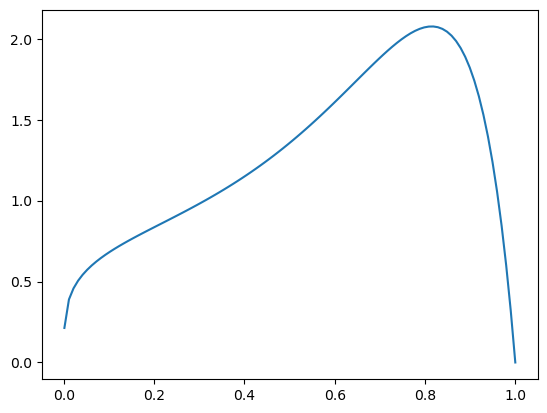

In [91]:
# Calculate the power actually ending up in the plasma driving current
current_drive_power = (1e-6)*P_electric*max_power_recirculation*wall_to_absorbed_RF_power_conversion_efficiency # [MW]

# Calculate the bootstrap fraction 
parallel_refraction = 1.67
bootstrap_fraction = 1 - 1.2*(current_drive_power)/(R0*(plasma_density)*Ip*(parallel_refraction**2))
print('The required bootstrap fraction is: ' + str(round(bootstrap_fraction, 2)))

# Calcualte the neoclassical bootstrap fraction 
# Current density J: 
rho = np.linspace(0.001, 1, 100)
a_hat = a*(k**0.5)
alpha = 2.53
x = rho**(9/4)
J = (Ip/(np.pi*(a_hat**2)))*((9*(rho**(1/4))/8))*(((alpha**2)*(1 - x)*np.e**(alpha*x))/(np.e**(alpha) - 1 - alpha))
plt.plot(rho, J)
J_integrated = np.sum(J)
b0 = (1/rho)*((1 + alpha - alpha*x)*np.e**(alpha*x) - 1 - alpha)/(np.e**(alpha) - 1 - alpha)
print(b0)
bootstrap_fraction_neoclassical = 268*(((a**(5/2))*(k**(5/4))*(plasma_pressure))/(mu_0*(R0**0.5)*(Ip**2)))*np.sum((rho**(5/2))*(1 - rho**2)/b0)

print(bootstrap_fraction_neoclassical)

# 